# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Change directory to where this file is located
"""

%cd '/content/drive/mldl1'

[Errno 2] No such file or directory: '/content/drive/mldl1'
/content


In [ ]:
import cv2
import PIL
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

Using PyTorch version: 2.0.0+cu118, Device: cuda


# Practice 1. Dataset and DataLoader (Visual Data)

## Explore CIFAR10 dataset

In [ ]:
cifar10 = datasets.CIFAR10(root="./CIFAR_10", train=True, download=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 38328839.32it/s]


Extracting ./CIFAR_10/cifar-10-python.tar.gz to ./CIFAR_10


In [ ]:
"""
This is the 1st element of the cifar10 train dataset.
"""

print(cifar10[0])


(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F21B13DBAC0>, 6)


In [ ]:
cifar10[4]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FB523BC3940>, 1)

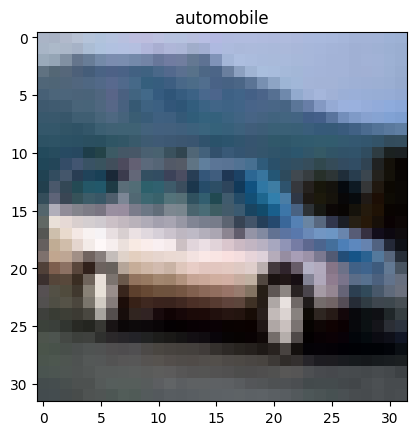

In [ ]:
"""
(1) Visualize the 5th element of the cifar10 train dataset with its label.

  - hint1: Use plt.imshow() function to visualize the image.
  - hint2: Use CIFAR10_LABEL to extract the label. With the given label index in the dataset, you can extract the label.
"""

CIFAR10_LABEL = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

########## Your Code #########
# Extract 5th element
data = cifar10[4]
image, label_idx = data
# Visualize image
plt.figure()
plt.title(CIFAR10_LABEL[label_idx])
plt.imshow(image)
plt.show()
##############################

## Custom Dataset

In [ ]:
"""
Customized dataset for CIFAR10

"""
class CustomDataset(Dataset):
    def __init__(self, train, data_dir="./CIFAR_10"):
        """
        Initializes the dataset.
        - loads CIFAR10 dataset to self.data
        """

        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)

    def __len__(self):
        """
        Returns the length of self.data.
        """

        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns data point with the given index.
        """
        return self.data[idx]

In [ ]:
train_dataset = CustomDataset(train=True)
test_dataset = CustomDataset(train=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
"""
(2) Convert the first 4 samples in the train_dataset to pytorch tensor and print their sizes and labels.

  - hint1: Use transforms.ToTensor() to convert image to pytorch tensor.
  - hint2: label information is given with CIFAR10_LABEL variable.
"""

fig = plt.figure()
for i in range(4):
    print(f"<Image no.{i}>")
    image, label_idx = train_dataset[i]

    ########## Your Code #########
    image = transforms.ToTensor()(image) # (H,W,C) -> (C, H, W)
    ##############################
    print(image.shape)

    ########## Your Code #########
    label = CIFAR10_LABEL[label_idx]
    ##############################
    print(label)

<Image no.0>
torch.Size([3, 32, 32])
frog
<Image no.1>
torch.Size([3, 32, 32])
truck
<Image no.2>
torch.Size([3, 32, 32])
truck
<Image no.3>
torch.Size([3, 32, 32])
deer


<Figure size 640x480 with 0 Axes>

## collate_fn

In [ ]:
"""
(3) Implement the function collate_fn.
"""

def collate_fn(data_samples):
    """Takes in the input samples from the Dataset, and makes them into a batch for the DataLoader.

    - Convert the PIL images in data_samples to pytorch tensors using ToTensor().
    - Convert the labels in data_samples to pytorch tensors.
      (hint : You should put the label in a list before transforming it into a tensor)
    - Append preprocessed image and label tensors to batch_x and batch_y respectively.
    - Convert the batch of image tensors into PyTorch float tensors.
    - Convert the batch of labels into PyTorch long tensors.
      (hint : Refer to the shapes of the Returns below)

    Args:
      data_samples: list of tuples, each containing a PIL image and an integer label

    Returns:
      batch_x: batch of image tensors. size: (BATCH, CHANNEL, HEIGHT, WIDTH)
      batch_y: batch of label tensors. size: (BATCH)
    """
    batch_x, batch_y = [], []
    ########## Your Code #########
    for image,label in data_samples:
      image = transforms.ToTensor()(image)
      label = torch.tensor([label])
      batch_x.append(image)
      batch_y.append(label)
    batch_x = torch.stack(batch_x) # 형태를 유지.
    batch_x = batch_x.float() # 형태를 유지하지 않고, 일렬로.
    batch_y = torch.cat(batch_y).long()
    ##############################
    return (batch_x, batch_y)

In [ ]:
batch_size = 8
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_fn)

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([8, 3, 32, 32])
torch.Size([8])


## Transforms (Data Augmentation)

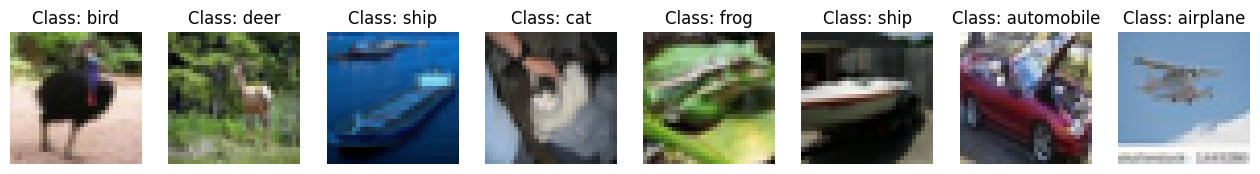

In [ ]:
def visualize_batch(batch, augment=None):
    images, labels = batch
    batch_size = images.shape[0]
    pltsize = 2
    plt.figure(figsize=(batch_size * pltsize, pltsize))
    for i in range(batch_size):
        plt.subplot(1, batch_size, i + 1)
        plt.axis('off')
        plt.imshow(np.transpose(augment(images[i]) if augment else images[i], (1, 2, 0)))
        plt.title('Class: ' + str(CIFAR10_LABEL[labels[i].item()]))

sample_batch = next(iter(train_loader))
visualize_batch(sample_batch)

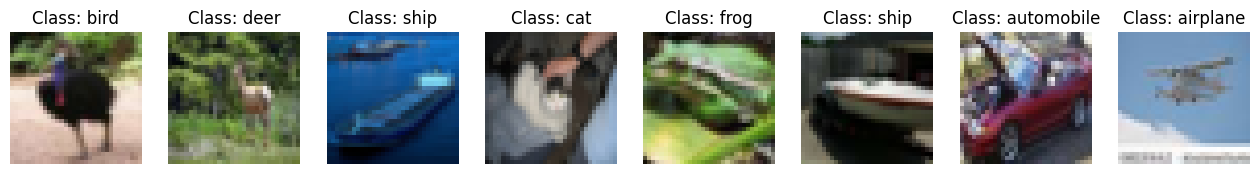

In [ ]:
"""
(4) Apply data augmentations using torchvision.transforms module.

- refererence: https://pytorch.org/vision/master/transforms.html
"""

########## Your Code #########
# This is the sample code. Try different augmentation methods!
#augment = transform.Grayscale(num_output_channels = 3)
#augment = transform.ColorJitter(brightness = 0.5, contrast=0.5, saturation=0.5, hue=0.5)
augment = transforms.RandomHorizontalFlip(p=0.5)
#augment = transform.RandomVerticalFlip(p=0.5)
#augment = transform.RandomResizedCrop((200,200), scale = (0.1,1), ratio = (0.5, 2))
visualize_batch(sample_batch, augment=augment)
##############################

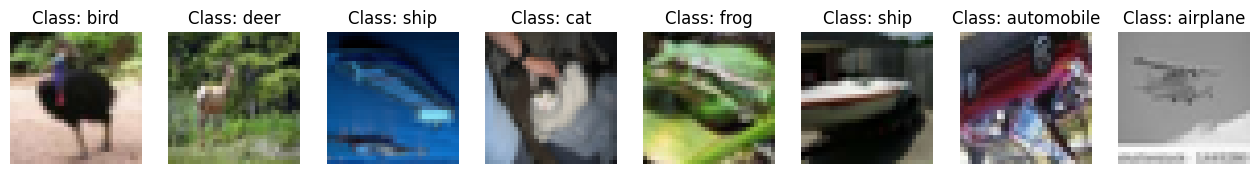

In [ ]:
"""
(5) Implement __call__(self, image) function in the RandomAugmenation class.
"""

augment_pool = [
    # Try other augmentation methods as well!
    transforms.Grayscale(num_output_channels=3),
    transforms.functional.hflip,
    transforms.functional.vflip,
]


class RandomAugmentation:
    def __init__(self, augment_pool, prob=0.5):
        self.augment_pool = augment_pool
        self.prob = prob

    def __call__(self, image):
        """Applies stochastic data augmentation to the given image.

        - Randomly choose the augmentation method from the augment_pool.
        - Random augmentation is applied with the probability of prob.
        - If prob = 0.5, 5 out of 10 images will be augmented on average.

        Args:
        image: An input image
        augment_pool: augmentation methods to apply
        prob: probability to apply augmentation

        Returns:
        image: augmented input image
        """
        ########## Your Code #########
        augment = self.augment_pool[np.random.randint(len(self.augment_pool))] # random하게 위 index중 하나를 가져오라는 것.
        image = augment(image) if np.random.randn() < self.prob else image # prob보다 작으면 augment, 아니면 원본.
        ##############################
        return image


visualize_batch(sample_batch, augment=RandomAugmentation(augment_pool, 0.8))

In [ ]:
"""
(6) Redefine customized dataset for CIFAR10

"""
class CustomDataset(Dataset):
    def __init__(self, train, transform=None, data_dir="./CIFAR_10"):
        """
        Initializes the dataset.

        - loads CIFAR10 dataset to self.data
        - assign transform to self.transform

        Args:
          train: If set to True, train dataset will be used.
          transform: If given, it will be applied to images when collate_fn is called.
          data_dir: Directory to download CIFAR10 dataset
        """
        ########## Your Code #########
        self.data = datasets.CIFAR10(root = data_dir, train = train, download = True)
        self.transform = transform
        ##############################

    def __len__(self):
        """
        Returns the length of self.data.
        """
        ########## Your Code #########
        return len(self.data)
        ##############################

    def __getitem__(self, idx):
        """
        Returns data point with the given index.
        """
        ########## Your Code #########
        return self.data[idx]
        ##############################

    def collate_fn(self, data_samples):
        """
        Takes in the input samples from the Dataset, and makes them into a batch for the DataLoader.

        - Convert the PIL images in data_samples to pytorch tensors using ToTensor().
        - Transform the image using self.transform method to apply random augmentation.
        - Convert the labels in data_samples to pytorch tensors.
        - Append preprocessed image and label tensors to batch_x and batch_y respectively.
        - Convert the batch of image tensors into PyTorch float tensors.
        - Convert the batch of labels into PyTorch long tensors.
        """
        batch_x, batch_y = [], []
        ########## Your Code #########
        for image, label in data_samples:
          image = transforms.ToTensor()(image)
          if self.transform:
            image = self.transform(image)
          label = torch.Tensor([label])
          batch_x.append(image)
          batch_y.append(label)
        batch_x = torch.stack(batch_x).float()
        batch_y = torch.cat(batch_y).long()
        ##############################
        return (batch_x, batch_y)

Files already downloaded and verified
Files already downloaded and verified


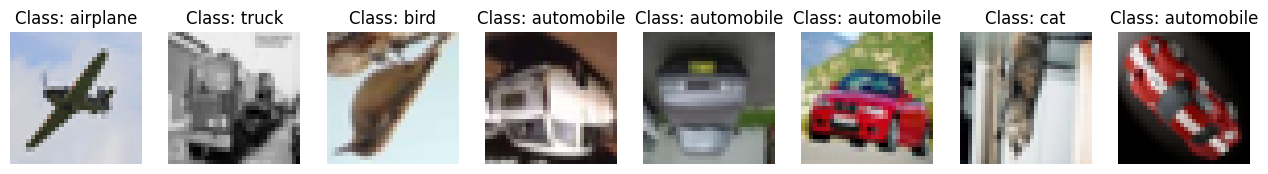

In [ ]:
train_dataset = CustomDataset(train=True, transform=RandomAugmentation(augment_pool, 0.5))
test_dataset = CustomDataset(train=False, transform=RandomAugmentation(augment_pool, 0.5))

batch_size = 8
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)

sample_batch = next(iter(train_loader))
visualize_batch(sample_batch)

# Practice 2. Train the Model (Convolutional Neural Network)

In [ ]:
train_dataset = CustomDataset(train=True, transform=None)
test_dataset = CustomDataset(train=False, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train(model, train_loader, optimizer, scheduler=None):
    model.train()
    train_loss = 0
    correct = 0
    tqdm_bar = tqdm(train_loader)
    for batch_idx, (image, label) in enumerate(tqdm_bar):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))
    if scheduler is not None:
        scheduler.step()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_loss, train_acc

In [ ]:
def evaluate(model, test_loader, return_samples=False):
    model.eval()
    test_loss = 0
    correct = 0

    random_idx = np.random.randint(len(test_loader))
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(tqdm(test_loader)):
            if batch_idx == random_idx:
                samples = (image, label)
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return (test_loss, test_acc, samples) if return_samples else (test_loss, test_acc)

## Multi Layer Perceptron

Perform architecture search to find the best MLP model.

In [ ]:
"""
(1) Define your own model (model hyperparameters)

  - which layers to use? how many layers to use?
  - which activation function to use?
"""

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        ########## Your Code #########
        # This is the sample code. Define your own model!
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        ##############################

    def forward(self, x):
        ########## Your Code #########
        # This is the sample code. Define your own model!
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        ##############################
        return x

In [ ]:
model = MLP().to(DEVICE)
criterion = nn.CrossEntropyLoss()

In [ ]:
"""
(2) Hyperparameter Tuning (training hyperparameters)

  - search different learning rates
  - try different batch size
  - try different optimizers
"""

########## Your Code #########
# This is the sample code. Try different hyperparameters!
learning_rate = 0.01
num_epochs = 5
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # could be sgd and etc.
##############################

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)

for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: MLP, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: MLP, 	Test Loss: 0.0149, 	Test Accuracy: 28.95 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: MLP, 	Test Loss: 0.0147, 	Test Accuracy: 31.27 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: MLP, 	Test Loss: 0.0144, 	Test Accuracy: 32.82 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: MLP, 	Test Loss: 0.0143, 	Test Accuracy: 32.96 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: MLP, 	Test Loss: 0.0146, 	Test Accuracy: 32.54 % 



## Convolutional Neural Network

Perform architecture search to find the best MLP model.

In [ ]:
"""
(1) Define your own model (model hyperparameters)

  - how many convolution, pooling, and fully connected layers to use?
  - how many channels to use in each convolution layer?
  - find the kernel size, padding, and strides with the best performance
  - which activation function to use?
"""

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ########## Your Code #########
        # This is the sample code. Define your own model!
        self.conv = nn.Sequential( ## 코드를 묶어서 깔끔하게 하기 위함.
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(), # flatten을 해줘야 Linear를 쓸 수 있음.
            nn.Linear(8 * 16 * 16, 10),
        )
        ##############################

    def forward(self, x):
        ########## Your Code #########
        # This is the sample code. Define your own model!
        x = self.conv(x)
        ##############################

        return x

In [ ]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()

In [ ]:
"""
(2) Hyperparameter Tuning (training hyperparameters)

  - search different learning rates
  - try different batch size
  - try different optimizers
"""

########## Your Code #########
# This is the sample code. Try different hyperparameters!
learning_rate = 0.001
num_epochs = 5
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##############################

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)

for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: CNN, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: CNN, 	Test Loss: 0.0122, 	Test Accuracy: 46.18 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: CNN, 	Test Loss: 0.0114, 	Test Accuracy: 49.34 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: CNN, 	Test Loss: 0.0110, 	Test Accuracy: 51.19 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: CNN, 	Test Loss: 0.0106, 	Test Accuracy: 53.19 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: CNN, 	Test Loss: 0.0104, 	Test Accuracy: 53.83 % 



## Learning Rate Scheduling

In [ ]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()

In [ ]:
"""
(1) Hyperparameter Tuning (training hyperparameters)

  - search different learning rates
  - try different batch size
  - try different optimizers
"""

########## Your Code #########
# This is the sample code. Try different hyperparameters!
learning_rate = 0.001
num_epochs = 5
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##############################

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)

In [ ]:
"""
(2) Try different learning rate scheduler

  - reference: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
"""

########## Your Code #########
# This is the sample code. Try different learning rate schedulers!
from torch.optim.lr_scheduler import ExponentialLR as ExponentialLR
scheduler = ExponentialLR(optimizer, gamma=0.9)
##############################

In [ ]:
for epoch in range(1, num_epochs + 1):
    curr_lr = scheduler.get_last_lr()[0]
    train(model, train_loader, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tModel: CNN, \tLR: {:.4f}, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, curr_lr, test_loss, test_accuracy))

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 1], 	Model: CNN, 	LR: 0.0010, 	Test Loss: 0.0125, 	Test Accuracy: 44.69 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 2], 	Model: CNN, 	LR: 0.0009, 	Test Loss: 0.0116, 	Test Accuracy: 48.36 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 3], 	Model: CNN, 	LR: 0.0008, 	Test Loss: 0.0110, 	Test Accuracy: 51.29 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 4], 	Model: CNN, 	LR: 0.0007, 	Test Loss: 0.0108, 	Test Accuracy: 51.38 % 



  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]


[EPOCH: 5], 	Model: CNN, 	LR: 0.0007, 	Test Loss: 0.0106, 	Test Accuracy: 52.41 % 



# TensorBoard

- https://pytorch.org/docs/stable/tensorboard.html
- https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html


In [ ]:
from torch.utils.tensorboard import SummaryWriter # 로그 기록 용도.

In [ ]:
def matplotlib_imshow(img):
    npimg = img.numpy()
    npimg = np.moveaxis(npimg, 0, -1)
    plt.imshow(npimg)

def images_to_probs(model, images):
    output = model(images.to(DEVICE))
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(out, dim=0)[pred_idx].item() for pred_idx, out in zip(preds, output)]

def plot_classes_preds(model, images, labels):
    preds, probs = images_to_probs(model, images)
    fig = plt.figure(figsize=(12, 24))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx])
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            CIFAR10_LABEL[preds[idx]],
            probs[idx] * 100.0,
            CIFAR10_LABEL[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

## 1. TensorBoard setup

In [ ]:
log_dir = "./runs/MLDL1_Lab2"
writer = SummaryWriter(log_dir=log_dir)

In [ ]:
%load_ext tensorboard

## 2. Tracking model training with TensorBoard

In [ ]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
num_epochs = 10
batch_size = 128
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.9)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn)

In [ ]:
for epoch in range(1, num_epochs + 1):
    curr_lr = scheduler.get_last_lr()[0]

    train_loss, train_accuracy = train(model, train_loader, optimizer, scheduler)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/train", train_accuracy, epoch)

    test_loss, test_accuracy, samples = evaluate(model, test_loader, return_samples=True)
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", test_accuracy, epoch)

    images, labels = samples
    writer.add_figure("Predictions vs Actuals",
                      plot_classes_preds(model, images, labels))

    print("\n[EPOCH: {}], \tModel: CNN, \tLR: {:.4f}, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, curr_lr, test_loss, test_accuracy))

In [ ]:
hparam_dict = {
    "lr": learning_rate,
    "num_epochs": num_epochs,
    "batch_size": batch_size,
}
metric_dict = {
    "accuracy": test_accuracy
}

writer.add_hparams(hparam_dict, metric_dict)

In [ ]:
writer.flush()
writer.close()

In [ ]:
%ls ./runs/MLDL1_Lab2

In [ ]:
%tensorboard --logdir ./runs